## load training triples

In [1]:
import json
import numpy as np

with open('training_data_pairs_shuffled.json', 'r') as f:
    loaded_data = json.load(f)

In [2]:
label_list = []
anchor_list = []
game_list = []

for entry in loaded_data:
    label_list.append(entry['label'])
    anchor_list.append(f"{entry['anchor']['id']} {entry['anchor']['features']} {entry['anchor']['description']}")
    game_list.append(f"{entry['game']['id']} {entry['game']['features']} {entry['game']['description']}")

In [3]:
print(np.array(anchor_list[0]))

1 Adventure Shooter Simulator Action Fantasy Stealth actionadventure blackjack bowandarrow crime darkness death difficultylevel ghosts immersive invisibility melee movingbodies pacifistplaythrough particlesystem pickpocketing polygonald potion realtimecombat shadowstealth singleplayeronly stealthkill steampunk swimming swordplay theft thief ultimate thief back tread softly make complex non-linear levels full loot steal guards outsmart improved enemy gadgets riveting story draw world thief metal place powerful technologies fanatical religions corruption game begins garrett continues life thief however betrayed fence ambushed early mission determines truart local sheriff hunting keepers take garrett hear prophecy metal ignores garrett leaves keepers informs truart hired kill gives garrett letter directs eavesdrop mechanist meeting garrett overhears truart father karras discussing conversion street people mindless servants wear masks emit vapor capable reducing nearby humans rust truart p

In [4]:
print(game_list[0])

2 Adventure Simulator Action Fantasy Stealth actionadventure assassin basketball betrayal blackjack bowandarrow bread crime darkness difficultylevel ghosts immersive instantkill invisibility magic maleprotagonist medieval melee movingbodies murder pacifistplaythrough particlesystem pickpocketing plottwist polygonald potion realtimecombat reluctanthero retailgameswithsteamactivation shadowstealth singleplayeronly stealthkill steampunk swimming swordplay theft thief tombraiding voiceacting thief first-person stealth game likes dark sneak ruins haunted cathedrals subterranean ruins forbidding prisons dark sinister city heavily inspired steampunk dark ages garrett finds ally shadows steals money uncovers hidden agendas allies enemies story unravels deception revenge


In [5]:
# import polars as pl
#
# label_list = []
# anchor_id_list = []
# anchor_features_list = []
# anchor_description_list = []
# game_id_list = []
# game_features_list = []
# game_description_list = []
# 
# for entry in loaded_data:
#     label_list.append(entry['label'])
#     anchor_id_list.append(entry['anchor']['id'])
#     anchor_features_list.append(entry['anchor']['features'])
#     anchor_description_list.append(entry['anchor']['description'])
#     game_id_list.append(entry['game']['id'])
#     game_features_list.append(entry['game']['features'])
#     game_description_list.append(entry['game']['description'])
# 
# data = {
#     'label': label_list,
#     'anchor_id': anchor_id_list,
#     'anchor_features': anchor_features_list,
#     'anchor_description': anchor_description_list,
#     'game_id': game_id_list,
#     'game_features': game_features_list,
#     'game_description': game_description_list
# }
# 
# df = pl.DataFrame(data)
# df.head()

In [6]:
# all_pairs_count = df.count().item(0,0)
# print(all_pairs_count)
# train_df = df.sample(all_pairs_count*0.8, shuffle=True, seed=24)
# print(train_df.describe())

In [7]:
# corpus = train_df.get_column('anchor_description') + train_df.get_column('game_description') + train_df.get_column('anchor_features') + train_df.get_column('game_features')
# print(corpus.shape)

In [8]:
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# 
# MAX_NUM_WORDS = 10000
# tokenizer = Tokenizer(MAX_NUM_WORDS)
# tokenizer.fit_on_texts(corpus)
# 
# A_train_description = tokenizer.texts_to_sequences(train_df.get_column('anchor_description'))
# B_train_description = tokenizer.texts_to_sequences(train_df.get_column('game_description'))
# 
# A_train_features = tokenizer.texts_to_sequences(train_df.get_column('anchor_features'))
# B_train_features = tokenizer.texts_to_sequences(train_df.get_column('game_features'))

In [9]:
# MAX_DESC_LENGTH = max([len(d) for d in A_train_description + B_train_description])
# MAX_FEAT_LENGTH = max([len(d) for d in A_train_features + B_train_features])
# print(f'MAX_DESC_LENGTH: {MAX_DESC_LENGTH} | MAX_FEAT_LENGTH: {MAX_FEAT_LENGTH}')

In [10]:
# A_train_description = pad_sequences(A_train_description, maxlen=MAX_DESC_LENGTH)
# B_train_description = pad_sequences(B_train_description, maxlen=MAX_DESC_LENGTH)
# 
# A_train_features = pad_sequences(A_train_features, maxlen=MAX_FEAT_LENGTH)
# B_train_features = pad_sequences(B_train_features, maxlen=MAX_FEAT_LENGTH)

In [11]:
# train_df.head()

In [12]:
# new_train_df = train_df.insert_column(1, pl.Series("A_description", A_train_description))
# new_train_df = new_train_df.insert_column(1, pl.Series("B_description", B_train_description))
# new_train_df = new_train_df.insert_column(1, pl.Series("A_features", A_train_features))
# new_train_df = new_train_df.insert_column(1, pl.Series("B_features", B_train_features))

In [13]:
# new_train_df = new_train_df.drop('anchor_features', 'anchor_description', 'game_features', 'game_description')
# new_train_df.head()

In [14]:
from sklearn.model_selection import train_test_split

train_anchor, temp_anchor, train_game, temp_game, train_labels, temp_labels = train_test_split(
    anchor_list,
    game_list,
    label_list,
    test_size=0.8, random_state=42)
val_anchor, test_anchor, val_game, test_game, val_labels, test_labels = train_test_split(
    temp_anchor,
    temp_game,
    temp_labels,
    test_size=0.5, random_state=42)

In [15]:
MAX_LENGTH = max([len(d) for d in anchor_list + game_list])
NUM_CLASSES = 1
MAX_TOKENS = 10000

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

anchor_input = tf.keras.Input(shape=(1,), name='anchor', dtype=tf.string)
game_input = tf.keras.Input(shape=(1,), name='game', dtype=tf.string)

vectorize_layer = layers.TextVectorization(max_tokens=MAX_TOKENS, output_mode='tf-idf') 
vectorize_layer.adapt(anchor_list)

A_vectorized = vectorize_layer(anchor_input)
B_vectorized = vectorize_layer(game_input)

embedding_layer = layers.Embedding(input_dim=MAX_LENGTH, output_dim=128)
A_embedded = embedding_layer(A_vectorized)
B_embedded = embedding_layer(B_vectorized)

shared_lstm = layers.LSTM(64)
A_output = shared_lstm(A_embedded)
B_output = shared_lstm(B_embedded)

merged = layers.concatenate(
    [A_output, B_output], 
    axis=-1)

dense1 = layers.Dense(
    units=32, 
    activation='relu')(merged)

dropout1 = layers.Dropout(0.5)(dense1)

dense2 = layers.Dense(
    units=16, 
    activation='relu')(dropout1)

dropout2 = layers.Dropout(0.5)(dense2)

dense3 = layers.Dense(
    units=NUM_CLASSES, 
    activation='sigmoid')

predictions = dense3(dropout2)

siamese_model = models.Model(inputs=[anchor_input, game_input],
                                  outputs=predictions, 
                                  name='siamese_model')

#custom_adam = Adam(learning_rate=0.01)
siamese_model.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

siamese_model.summary()

2024-01-28 00:36:16.741428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 00:36:16.741475: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 00:36:16.761889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 00:36:16.808951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 00:36:17.630577: W tensorflow/compiler/tf2

Model: "siamese_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 game (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization (TextVe  (None, 10000)                1         ['anchor[0][0]',              
 ctorization)                                                        'game[0][0]']                
                                                                                                  
 embedding (Embedding)       (None, 10000, 128)           1782272   ['text_vectorizati

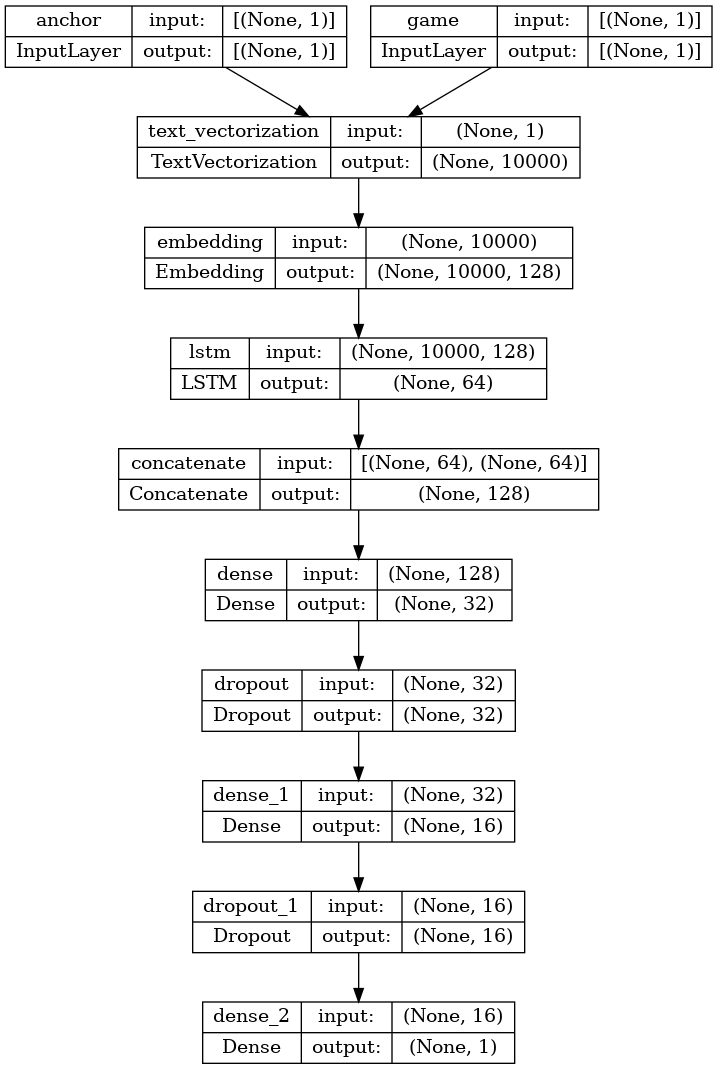

In [17]:
from keras.utils import plot_model

plot_model(siamese_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
history = siamese_model.fit(
    [np.array(train_anchor), np.array(train_game)],
    np.array(train_labels),
    epochs=10,
    batch_size=128,
    use_multiprocessing=True,
    workers=10,
    shuffle=True,
    validation_data=([np.array(val_anchor), np.array(val_game)], np.array(val_labels))
)

Epoch 1/10


2024-01-28 00:37:38.394596: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-28 00:37:39.544478: I external/local_xla/xla/service/service.cc:168] XLA service 0x748bf1b3e4b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-28 00:37:39.544498: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-28 00:37:39.552873: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706398659.631171  149099 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


443/443 [==============================] - 472s 1s/step - loss: 0.6646 - accuracy: 0.6282 - val_loss: 0.6601 - val_accuracy: 0.6283
Epoch 2/10
443/443 [==============================] - 449s 1s/step - loss: 0.6599 - accuracy: 0.6309 - val_loss: 0.6597 - val_accuracy: 0.6283
Epoch 3/10
443/443 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.6302

KeyboardInterrupt: 

In [ ]:
siamese_model.save('siamese_model_v2.keras')

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_accuracy = siamese_model.evaluate(
    (np.array(test_anchor), np.array(test_game)),
    np.array(test_labels),
)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')